In [1]:
import math
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fiona
import geopandas as gpd
from shapely import geometry
from scipy import sparse
from scipy import spatial
import seaborn as sns
%matplotlib inline

In [2]:
# READ NODE INFO
nodes = {}

with open('arb_sites.yml', 'r') as stream:
    nodes.update(yaml.load(stream))
    
nodes.update({'USGS04174518' : {'elevation' : None,
                               'latitude' : 42.264722,
                               'longitude' : -83.688333,
                               'name' : 'Malletts Creek'}})

In [3]:
junctions = gpd.read_file('/Users/mdbartos/Data/GIS/Ann Arbor/full ann arbor 090216/junctions.shp')
subcatchments = gpd.read_file('/Users/mdbartos/Data/GIS/Ann Arbor/full ann arbor 090216/subcatchments.shp')
conduits = gpd.read_file('/Users/mdbartos/Data/GIS/Ann Arbor/full ann arbor 090216/conduits.shp')
orifices = gpd.read_file('/Users/mdbartos/Data/GIS/Ann Arbor/full ann arbor 090216/orifices.shp')
outfalls = gpd.read_file('/Users/mdbartos/Data/GIS/Ann Arbor/full ann arbor 090216/outfalls.shp')
outlets = gpd.read_file('/Users/mdbartos/Data/GIS/Ann Arbor/full ann arbor 090216/outlets.shp')
pumps = gpd.read_file('/Users/mdbartos/Data/GIS/Ann Arbor/full ann arbor 090216/pumps.shp')
storages = gpd.read_file('/Users/mdbartos/Data/GIS/Ann Arbor/full ann arbor 090216/storages.shp')
weirs = gpd.read_file('/Users/mdbartos/Data/GIS/Ann Arbor/full ann arbor 090216/weirs.shp')

In [4]:
#This shapefile is broken
#dividers = gpd.read_file('/Users/mdbartos/Data/GIS/Ann Arbor/full ann arbor 090216/dividers.shp')

In [5]:
# NODES
subcatchment_names = subcatchments['NAME']
junction_names = junctions['NAME']
outfall_names = outfalls['NAME']
storage_names = storages['NAME']
node_names = pd.concat([subcatchment_names, junction_names, outfall_names, storage_names])

In [6]:
# LINKS
subcatch_link = subcatchments[['NAME', 'NAME', 'OUTLET']]
subcatch_link.columns = ['NAME', 'INLETNODE', 'OUTLETNODE']
conduit_names = conduits[['NAME', 'INLETNODE', 'OUTLETNODE']]
orifice_names = orifices[['NAME', 'INLETNODE', 'OUTLETNODE']]
pump_names = pumps[['NAME', 'INLETNODE', 'OUTLETNODE']]
outlet_names = outlets[['NAME', 'INLETNODE', 'OUTLETNODE']]
weir_names = weirs[['NAME', 'INLETNODE', 'OUTLETNODE']]
link_names = pd.concat([conduit_names, orifice_names, pump_names, outlet_names, weir_names, subcatch_link])

In [7]:
# GET UNIQUE NODES
unique_nodes = pd.concat([node_names,
                         link_names['NAME'], link_names['INLETNODE'], 
                          link_names['OUTLETNODE']]).unique()
unique_nodes = pd.Series(np.arange(len(unique_nodes)), index=unique_nodes)

In [8]:
allnodes = pd.concat([junctions[['NAME', 'geometry']], 
                      outfalls[['NAME', 'geometry']], 
                      storages[['NAME', 'geometry']]])

In [9]:
# MAP INLET NODES TO OUTLET NODES
inletmap = link_names['INLETNODE'].map(unique_nodes)
outletmap = link_names['OUTLETNODE'].map(unique_nodes)
links = pd.concat([inletmap, outletmap], axis=1)
inletnodes = links['INLETNODE'].values
outletnodes = links['OUTLETNODE'].values

In [10]:
# BOOKKEEPING
max_ix = np.concatenate([inletnodes, outletnodes]).max() + 1
max_ix

14266

In [11]:
# GET XY COORDS OF JUNCTIONS AND CONSTRUCT TREE
junc_xy = np.asarray(junctions.to_crs(epsg=4326).geometry
                     .apply(lambda x: x.coords[0]).values.tolist())
tree = spatial.cKDTree(junc_xy)

In [12]:
# CONSTRUCT DIRECTED GRAPH
A = sparse.lil_matrix((unique_nodes.values.size, unique_nodes.values.size))
for i,j in zip(inletnodes, outletnodes):
    # Reversed
    A[j,i] = 1

C = A.tocsr()
del A

In [13]:
# TEST ON MALLETTS CREEK

In [14]:
y, x = nodes['USGS04174518']['latitude'], nodes['USGS04174518']['longitude']

In [15]:
dist, ix = tree.query([x, y])
end_name = junction_names.iloc[ix]
end_num = unique_nodes.loc[end_name]
spath = sparse.csgraph.shortest_path(C, indices=[end_num], directed=True).ravel()
in_network = np.where(np.isfinite(spath))[0]
in_network_labels = unique_nodes.iloc[in_network].index.values
in_network_shp = gpd.GeoDataFrame((allnodes.set_index('NAME').loc[in_network_labels]
                                  .dropna(axis=0, how='all').reset_index()),
                                 crs=junctions.crs)
subsubcatch = (subcatchments[subcatchments['OUTLET'].isin(in_network_shp['NAME'].values)])

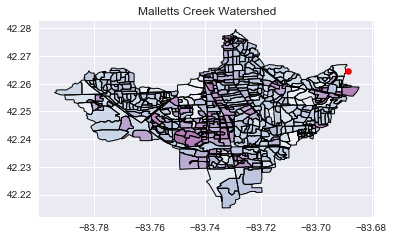

In [16]:
subsubcatch.to_crs(epsg=4326).plot(column='IMPERV', cmap='BuPu')
plt.scatter([x], [y], s=40, c='r')
plt.title('Malletts Creek Watershed')

In [17]:
nodeset = [i for i in nodes.keys() if not i in 
           ('ohm_rain_garden', 'north_territorial',
            'kensington', 'ecorse_creek_autosampler',
            'woodruff_creek_autosampler',
            'toledo_bioswale', 'toledo_zoo',
            'milwaukee_0')]

In [18]:
subsubcatches = {}

for node in nodeset:
    y, x = nodes[node]['latitude'], nodes[node]['longitude']
    if y and x:
        dist, ix = tree.query([x, y])
        end_name = junction_names.iloc[ix]
        end_num = unique_nodes.loc[end_name]
        spath = sparse.csgraph.shortest_path(C, indices=[end_num], directed=True).ravel()
        in_network = np.where(np.isfinite(spath))[0]
        in_network_labels = unique_nodes.iloc[in_network].index.values
        in_network_shp = gpd.GeoDataFrame((allnodes.set_index('NAME').loc[in_network_labels]
                                      .dropna(axis=0, how='all').reset_index()),
                                      crs=junctions.crs)
        subsubcatch = (subcatchments[subcatchments['OUTLET']
                                     .isin(in_network_shp['NAME'].values)])
        subsubcatches[node] = subsubcatch

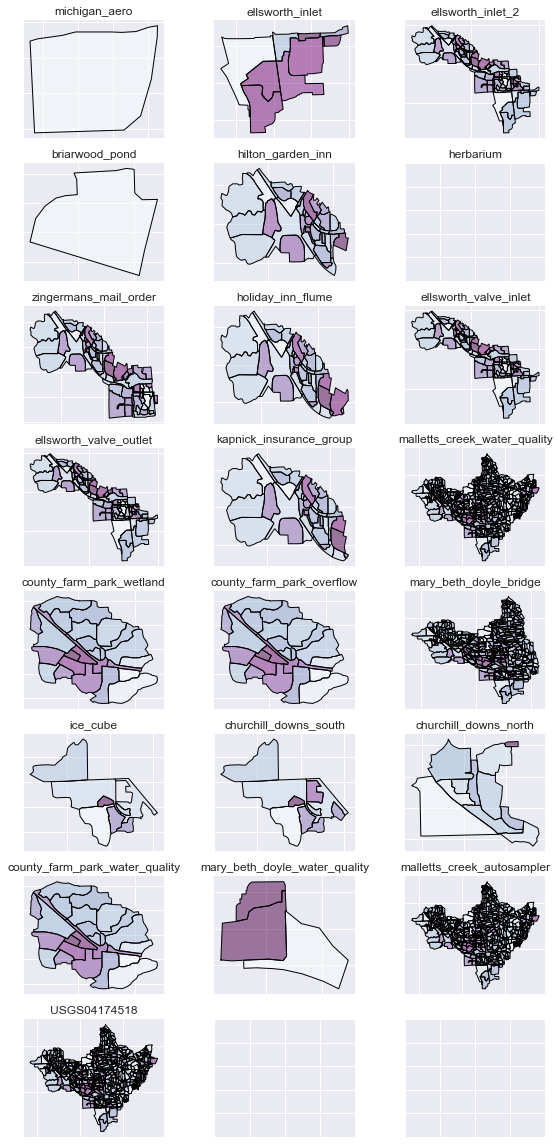

In [19]:
fig, ax = plt.subplots(math.ceil(len(subsubcatches.keys()) / 3), 3, figsize=(8, 16))

for i, catch in enumerate(subsubcatches.keys()):
    ax.flat[i].set_title(catch)
    if len(subsubcatches[catch]) > 0:
        subsubcatches[catch].plot(ax=ax.flat[i], cmap='BuPu', column='IMPERV')

for i in range(ax.size):
    ax.flat[i].get_xaxis().set_ticklabels([])
    ax.flat[i].get_yaxis().set_ticklabels([])
        
plt.tight_layout()

In [20]:
unary_subsubcatches = {}

for catch in subsubcatches:
    if len(subsubcatches[catch]) > 0:
        unary_subsubcatches[catch] = (gpd.GeoSeries(subsubcatches[catch].unary_union)
                                      .explode()[0])

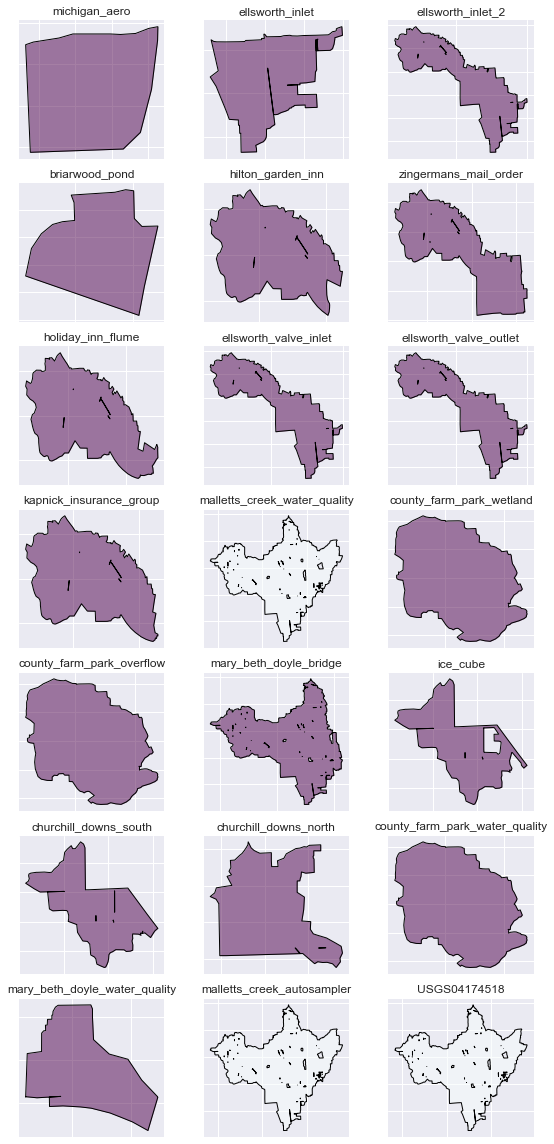

In [21]:
fig, ax = plt.subplots(math.ceil(len(unary_subsubcatches.keys()) / 3), 3, figsize=(8, 16))

for i, catch in enumerate(unary_subsubcatches.keys()):
    ax.flat[i].set_title(catch)
    if len(unary_subsubcatches[catch]) > 0:
        unary_subsubcatches[catch].plot(ax=ax.flat[i], cmap='BuPu')

for i in range(ax.size):
    ax.flat[i].get_xaxis().set_ticklabels([])
    ax.flat[i].get_yaxis().set_ticklabels([])
        
plt.tight_layout()

In [22]:
# WRITE TO FILE
for subcatch in subsubcatches:
    if len(subsubcatches[subcatch]) > 0:
        subsubcatches[subcatch].to_file('./shp/{0}.shp'.format(subcatch))
    
for subcatch in unary_subsubcatches:
    if len(subsubcatches[subcatch]) > 0:
        unary_subsubcatches[subcatch].to_file('./shp/{0}_unary.shp'.format(subcatch))

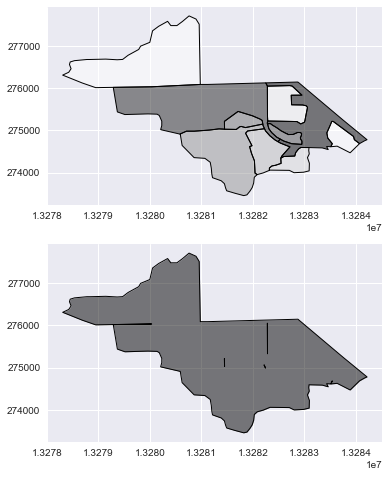

In [23]:
test = gpd.read_file('./shp/churchill_downs_south.shp')
test_u = gpd.read_file('./shp/churchill_downs_south_unary.shp')

fig, ax = plt.subplots(2, figsize=(6, 8))

test.plot(ax=ax[0])
test_u.plot(ax=ax[1])